**Aluno:** Douglas Leite Leal Moura

**Matrícula:** 2020715184

**Trabalho Prático I - Machine Learning**

_Classificação de Exoplanetas_

### Objetivo

O objetivo deste trabalho prático é de praticar os conceitos aprendidos na disciplina e de adquirir experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na interpretação e apresentação de resultados de experimentos. Para isso você irá utilizar e comparar métodos de classificação baseados em princı́pios diferentes em um problema de classificação binária de candidatos a exoplanetas.

* **Naive Bayes:** Apenas um experimento para servir de baseline
* **Decision Tree:** Variar a altura máxima da árvore (incluindo permitir altura ilimitada) e
mostrar os resultados graficamente
* **SVM:** Avaliar os kernels linear, sigmoid, polinomial e RBF
* **k-NN:** Variar o número k de vizinhos e mostrar os resultados graficamente
* **Random Forest:** Variar o número de árvores e mostrar os resultados graficamente.
* **Gradient Tree Boosting:** Variar o número de iterações e mostrar os resultados graficamente

### Instruções

Este trabalho utiliza a bibliteca _scikit-learn_ da linguagem Python (versão 3.6).

O ambiente virtual pode ser configurado mediante a execução dos seguintes comandos no terminal:

A sequência de comandos abaixo faz os imports necessários para a execução dos experimentos:

In [146]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from tabulate import tabulate
# classificadores
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Conjunto de dados

O conjunto de dados foi importado utilizando _Pandas_, uma poderosa biblioteca Python criada para a manipulação e análise de dados.

O arquivo `koi_data.csv` trata-se do conjunto de dados utilizado neste problema de classificação binária de candidatos a exoplanetas. Um exoplaneta é um planeta fora do sistema solar (i.e. que não orbita o sol). A sonda primeiro identifica sinais de possı́veis exoplanetas, chamados de Kepler Object of Interest (KOI). Porém, nem todos os KOIs são de fato exoplanetas, alguns se tratam de falsos positivos de origens diversas. A tarefa é então classificar os KOIs entre exoplanetas confirmados e falsos positivos.

In [6]:
# caminho do arquivo
KOI_PATH = os.path.join("datasets", "TP1", "")

# funcao para importar o csv utilizando a lib pandas
def load_koi_data(koi_path=KOI_PATH):
    csv_path = os.path.join(koi_path, "koi_data.csv")
    return pd.read_csv(csv_path)

# importando dados
koi = load_koi_data()

A base de dados contém 5202 linhas e 43 colunas.

A primeira coluna identifica o KOI, a segunda traz a sua classificação correta (FALSE POSITIVE ou CONFIRMED) e as demais colunas são features sobre o KOI extraı́das de diversas formas.

In [7]:
koi.head() # Exibe as 5 primeiras linhas do dataset.

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Cada observação corresponde a um KOI e as features são caracterı́sticas estimadas de cada (possı́vel) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).

### Tratamento dos dados

A função `koi.info()` revelou que não havia dandos ausentes no conjunto de dados.

Sendo assim, não houve necessidade de adotar procedimentos para preencher os dados ausentes.

A partir de uma inspeção no conjunto de dados foi possível obter alguns _insights_. Por exemplo, a feature `kepoi_name` é um atributo categórico que descreve o nome do planeta, ela possui pouco potencial preditivo. Por isso, é interessante removê-la do conjunto de dados.

Em seguida, o atributo `koi_disposition` foi atribuído à variável `y_train` para ser utilizado como rótulo.

In [8]:
# verifica o tipo dos atributos e se existem dados faltantes.
koi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepoi_name        5202 non-null   object 
 1   koi_disposition   5202 non-null   object 
 2   koi_period        5202 non-null   float64
 3   koi_impact        5202 non-null   float64
 4   koi_duration      5202 non-null   float64
 5   koi_depth         5202 non-null   float64
 6   koi_ror           5202 non-null   float64
 7   koi_srho          5202 non-null   float64
 8   koi_prad          5202 non-null   float64
 9   koi_sma           5202 non-null   float64
 10  koi_incl          5202 non-null   float64
 11  koi_teq           5202 non-null   float64
 12  koi_insol         5202 non-null   float64
 13  koi_dor           5202 non-null   float64
 14  koi_max_sngle_ev  5202 non-null   float64
 15  koi_max_mult_ev   5202 non-null   float64
 16  koi_model_snr     5202 non-null   float64


#### Distribuição dos dados

Após o tratamento inicial dos dados, observou-se a distribuição dos dados.

A função `X.describe()` sumariza algumas informações extraídas de cada feature, como a média, desvio padrão e os quartis.

No geral, foi possível perceber diferenças nas escalas dos atributos. Sendo necessário normalizar os dados. A fim de evitar vazamento de dados, a normalização foi realizada posteriormente, após o particionamento dos dados.

In [9]:
# remove a feature 'kepoi_name'.
columns = ['kepoi_name']
koi = koi.drop(columns=columns)

# remove a feature 'koi_position', pois ele e a classe que queremos predizer.
X = koi.drop("koi_disposition", axis=1)
y = koi["koi_disposition"].copy()

# fornece uma visao geral da distribuicao dos dados
X.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,37.032237,0.717106,5.607025,21340.318993,0.235205,3.415370,112.230798,0.158146,81.181413,1143.721069,...,-0.355681,-0.805629,-0.000263,0.000439,-0.049743,-0.087413,1.930251,-0.038402,-0.098738,1.920226
std,88.417985,2.628207,6.962634,66989.808550,2.586213,25.131368,3699.799318,0.241792,16.308839,775.788868,...,10.978677,14.741473,0.065707,0.077519,2.465670,2.746534,3.147553,2.465094,2.734732,3.142764
min,0.306940,0.000000,0.104600,0.800000,0.001290,0.000040,0.080000,0.007200,2.290000,92.000000,...,-275.600000,-397.620000,-4.000000,-0.800000,-21.500000,-75.900000,0.000000,-23.600000,-76.600000,0.000000
25%,2.213962,0.226000,2.500250,176.800000,0.013058,0.176092,1.460000,0.033000,81.930000,615.250000,...,-0.500000,-0.570000,-0.000240,-0.000240,-0.270000,-0.291500,0.128250,-0.265250,-0.320000,0.180000
50%,7.386755,0.610000,3.805500,495.950000,0.024185,0.748045,2.600000,0.073650,87.890000,948.000000,...,0.000000,-0.030000,0.000000,0.000000,0.000000,0.000000,0.460000,-0.007000,-0.018000,0.453000
75%,23.448117,0.923750,6.000750,2120.525000,0.171260,2.267063,21.645000,0.158200,89.520000,1482.000000,...,0.500000,0.450000,0.000260,0.000280,0.230000,0.230000,2.570000,0.226250,0.250000,2.420000
max,1071.232620,100.806000,138.540000,864260.000000,99.870650,918.752390,200346.000000,2.034500,90.000000,9791.000000,...,97.780000,98.780000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,31.200000,89.600000


Por fim, foi analisado a distribuição dos exemplos entre as classes. O histograma revelou um certo desbalanceamento na distribução, onde cerca de 40.45% dos exemplos pertence a classe `CONFIRMED` e 59.55% pertence a classe `FALSE POSITIVE`, uma diferença de aproximadamente 19.10%.

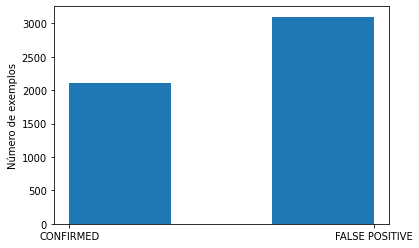

In [10]:
# plota um histograma de y.
plt.hist(y, bins=3)
plt.ylabel('Número de exemplos')
plt.show()

### Funções Auxiliares

Algumas funções e classes foram implementadas para auxiliar os experimentos de treinamento e visualização dos resultados.

A classe `Scores` foi criada para facilitar o cálculo e visualização das métricas de desempenho.

O classificador irá treinar o modelo e registrar as métricas na classe `Scores` por meio do método `adicionar`. Esta classe também fornece a média e o desvio padrão da acurácia.

In [49]:
class Scores(object):
    """Registra as métricas de desempenho."""
    def __init__(self):
        self.accuracy = []
        self.fpr = []
        self.tpr = []
        self.precision = []
        self.recall = []
        self.f1 = []
        self.folds = 0
        
    def mean(self):
        """Retorna a media da acuracia."""
        return np.mean(self.accuracy)
    
    def std(self):
        """Calcula o desvio padrao da acuracia."""
        return np.std(self.accuracy)        
    
    def adicionar(self, accuracy, fpr, tpr, precision, recall, f1):
        """Adiciona as métricas de cada fold."""
        self.accuracy.append(accuracy)
        self.fpr.append(fpr)
        self.tpr.append(tpr)
        self.precision.append(precision)
        self.recall.append(recall)
        self.f1.append(f1)
        self.folds += 1 # incrementa o numero de folds

A função `show_scores` utiliza a biblioteca `tabulate` para produzir um relatório contendo as métricas de precision, recall, F1-score de cada fold, além de uma média. 

In [43]:
def show_scores(precision, recall, f1, folds):
        """Mostra uma tabela com as métricas de desempenho."""
        table = []
        matrix = np.zeros((folds, 4))
        
        # metrica para cada fold.
        for i in range(folds):
            row = []
            matrix[i,:] = [int(i), np.mean(precision[i]), np.mean(recall[i]), np.mean(f1[i])]
            row.append(i) # numero de folds
            row.append(format(matrix[i,1], '.3f')) # media do precision
            row.append(format(matrix[i,2], '.3f')) # media do recall
            row.append(format(matrix[i,3], '.3f')) # media do f1
            table.append(row)
        
        # media
        row = []
        media = list(matrix[:,1:].mean(0))
        row.append("Média")
        row.append(format(media[0], '.3f'))
        row.append(format(media[1], '.3f'))
        row.append(format(media[2], '.3f'))
        
        table.append(row)

        names = ["# fold", "Precision", "Recall", "F1-score"]
        table = tabulate(table, headers=names, tablefmt="pretty")
    
        return table

In [135]:
def plt_parametro(X, y, model, params):
    """Função para gerar o gráfico da acurácia."""
    param_grid = ParameterGrid(params)
    mean = []
    std = []
    x = []
    xlab = list(params)[0]
    
    for params in param_grid:
        x += (params.values())
        model.set_params(**params)
        clf = Classificador(X, y, model)
        clf.treinar()
        mean.append(clf.scores.mean())
        std.append(clf.scores.std())

    # Plota a média e o desvio padrão do cross-validation.
    plt.figure()
    plt.errorbar(x, mean, yerr=std)
    plt.title("Acurácia do cross-validation")
    plt.xlabel(xlab)
    plt.ylabel("Acurácia")
    plt.ylim(0.8, 1) 
    plt.show()

In [136]:
def plt_roc(fpr, tpr, folds):
    """Função para gerar o gráfico da curva ROC."""
    
    plt.figure()
    colors = ['blue', 'green', 'purple', 'orange', 'yellow']
    mean_fpr = np.linspace(0,1,100)
    tprs = []
    # Irá gerar uma curva para cada fold.
    for i in range(folds):
        lbl = "Fold {}".format(i)
        plt.plot(fpr[i], tpr[i], color=colors[i], alpha=0.3, linewidth=2, label=lbl)
        tprs.append(np.interp(mean_fpr, fpr[i], tpr[i]))
    
    # Irá plotar a média dos folds
    mean_tpr = np.mean(tprs, axis=0)
    plt.plot(mean_fpr, mean_tpr, "b:", linewidth=2, label="Média")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("Curva ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

### Método de Validação Cruzada

Como forma de melhor avaliar a capacidade de generalização dos modelos analisados, adotou-se o método de valizadação cruzada por meio do k-fold.

O conjunto de dados foi particionado em 5 folds. Desta forma, cada partição será utilizada para treino e teste.

Como forma de evitar vazamento de dados, o processo de normalização dos dados foi executado em cada fold seguindo a seguinte função:

`z = (x - u) / s`

Onde `u` é a média dos exemplos de treinamento `x` e `s` é o desvio padrão.

In [145]:
class Classificador(object):
    '''Classe responsável por treinar o modelo.'''
    
    def __init__(self, X, y, model, folds=5):
        
        self.X = X # Conjunto de dados
        self.y = y # Classe dos dados
        self.model = model # Modelo usado para treinar
        self.folds = folds # Numero de k-folds (default 5).
        self.scores = Scores() # Metricas do classificador
    
    def treinar(self):
        """Treina o classificador usando o k-fold."""

        skf = StratifiedKFold(n_splits=self.folds, shuffle=False)

        for train_index, test_index in skf.split(self.X, self.y):
            X_train,X_test = X.iloc[train_index],X.iloc[test_index]
            y_train,y_test = y.iloc[train_index],y.iloc[test_index]

            # normalização
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # treinamento
            self.model.fit(X_train,y_train)
            y_pred = self.model.predict(X_test).reshape(-1,)
            
            # calcula todos os scores
            accuracy = accuracy_score(y_test, y_pred) # acurácia
            y_pred_proba = self.model.predict_proba(X_test)[::,0]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label="CONFIRMED") # curva roc
            precision = precision_score(y_test, y_pred, pos_label='CONFIRMED') # precision
            recall = recall_score(y_test, y_pred, pos_label='CONFIRMED') # recall
            f1 = f1_score(y_test, y_pred, pos_label='CONFIRMED') # f1-score
            
            # salva os scores
            self.scores.adicionar(accuracy, fpr, tpr, precision, recall, f1)

        return self.model

Para facilitar o processo de descoberta do melhor conjunto de hiper-parâmetros, foi proposta uma função `find_parameters`, que recebe como entrada o conjunto de dados, a classe, o modelo e um dicionário de hiper-parâmetros.

A função irá realizar todas as combinações, treinar o algoritmo e, ao final, informar qual configuração obteve a melhor acurácia.

In [143]:
def find_parameters(X, y, model, params):
    """Função responsável por analisar os parâmetros do modelo."""
    
    param_grid = ParameterGrid(params)
    best_score = 0
    best_params = None
    best_clf = None
    
    print("Analisando ({}) combinações de parâmetros:".format(len(param_grid)))
    print("+----------------------------------------+")
    for params in param_grid:
        model.set_params(**params)
        clf = Classificador(X, y, model)
        clf.treinar()
        
        # verifica se a acuracia é melhor que a atual.
        if clf.scores.mean() > best_score:
            best_score = clf.scores.mean()
            best_params = params
            best_clf = clf
        
        print("Acurácia: {:.3} (+/- {:.3}) for {} ".format(clf.scores.mean(), clf.scores.std(), params))
    
    print("+----------------------------------------+")
    print("Melhor: {}".format(best_params))
    return best_clf

## Resultados

Esta parte do documento relata os resultados inicial para cada algoritmo.

### 1. Naive Bayes

**Tarefa:** Apenas um experimento para servir de baseline.

Para esta tarefa foi utilizado o classificador `GaussianNB`. Não foi solicitado nenhuma análise de parâmetro.

Analisando (1) combinações de parâmetros:
+----------------------------------------+
0.9146839701994712
0.9139629896659457
0.915185007208073
0.9108601633829889
0.9279192695819317
Acurácia: 0.919 (+/- 0.0171) for {} 
+----------------------------------------+
Melhor: {}
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.826   | 0.950  |  0.884   |
|   1    |   0.831   | 0.971  |  0.896   |
|   2    |   0.865   | 0.976  |  0.917   |
|   3    |   0.888   | 0.995  |  0.938   |
|   4    |   0.849   | 0.948  |  0.895   |
| Média  |   0.852   | 0.968  |  0.906   |
+--------+-----------+--------+----------+


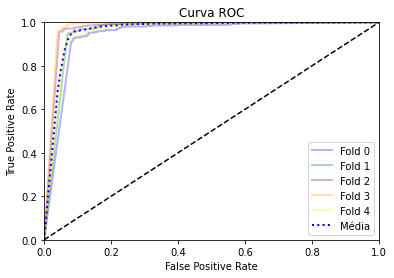

In [144]:
# Classificador
gnb = GaussianNB()

# Hiper-parametros
params = {}

# Melhor classificador
gnb = find_parameters(X, y, gnb, params)

# Estatisticas do melhor
s = gnb.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

# Curva ROC do melhor
plt_roc(s.fpr, s.tpr, s.folds)

O Naive Bayes obteve uma acurácia de aproximadamente 92%. Em termos gerais, o classificador mostrou uma boa performance para o problema em questão, sendo capaz de classificar corretamente quase todas as instâncias de teste.

As medidas de precisão e revocação fornecem uma análise mais detalhada da performance do classificador.

A precisão foi por volta de 85%, cerca de 15% dos planetas foram classificados como `CONFIRMED` quando na verdade eram `FALSE POSITIVE`.

Por outro lado, a revocação de quase 97% sugere que o Naive Bayes conseguiu classificar bem casos onde o planeta era de fato `CONFIRMED`, estes resultados sugerem que o classificador possui uma alta sensibilidade aos casos positivos.

Por fim, o F1-Score também foi calculado. Para este caso, devido a precisão de 85%, o F1-Score foi de 90%.

Conforme será visto nos resultados abaixo, outros classificadores obtiveram uma precisão acima de 90%.

### 2. Decision Tree

**Tarefa:** Variar a altura máxima da árvore (incluindo permitir altura ilimitada) e
mostrar os resultados graficamente.

A árvore de decisão utilizou a **entropia** como medida de impureza.



Analisando (12) combinações de parâmetros:
+----------------------------------------+
Acurácia: 0.908 (+/- 0.0248) for {'criterion': 'entropy', 'max_depth': 2} 
Acurácia: 0.939 (+/- 0.0178) for {'criterion': 'entropy', 'max_depth': 4} 
Acurácia: 0.952 (+/- 0.00847) for {'criterion': 'entropy', 'max_depth': 8} 
Acurácia: 0.95 (+/- 0.0116) for {'criterion': 'entropy', 'max_depth': 16} 
Acurácia: 0.953 (+/- 0.0126) for {'criterion': 'entropy', 'max_depth': 32} 
Acurácia: 0.95 (+/- 0.012) for {'criterion': 'entropy', 'max_depth': 64} 
Acurácia: 0.865 (+/- 0.0471) for {'criterion': 'gini', 'max_depth': 2} 
Acurácia: 0.94 (+/- 0.0158) for {'criterion': 'gini', 'max_depth': 4} 
Acurácia: 0.945 (+/- 0.0188) for {'criterion': 'gini', 'max_depth': 8} 
Acurácia: 0.941 (+/- 0.0177) for {'criterion': 'gini', 'max_depth': 16} 
Acurácia: 0.939 (+/- 0.0183) for {'criterion': 'gini', 'max_depth': 32} 
Acurácia: 0.937 (+/- 0.0234) for {'criterion': 'gini', 'max_depth': 64} 
+----------------------------

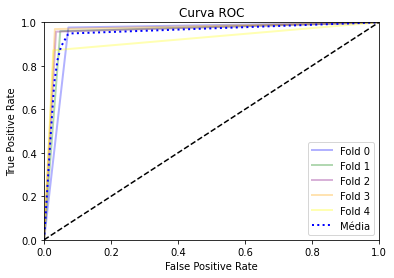

In [128]:
params = {"max_depth":[2, 4, 8, 16, 32, 64],
          "criterion":["entropy", "gini"]}

tree = DecisionTreeClassifier()

# Melhor classificador
tree = find_parameters(X, y, tree, params)

# Estatisticas do melhor
s = tree.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

# Curva ROC do melhor
plt_roc(s.fpr, s.tpr, s.folds)

A árvore de decisão resultante pode ser visualizada abaixo com o auxílio da função **plot_tree**:

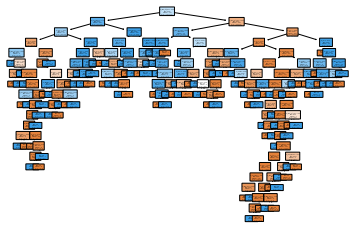

In [141]:
feature_names = list(X.columns.values)
class_names = tree.model.classes_

plt.figure()
plot_tree(tree.model,
               feature_names=feature_names,
               class_names=class_names,
               filled=True, rounded=True) 
plt.show()

### 3. SVM

Avaliar os kernels linear, sigmoid, polinomial e RBF.

Analisando (3) combinações de parâmetros:
+----------------------------------------+
Acurácia: 0.942 (+/- 0.0202) for {'C': 0.1, 'kernel': 'linear', 'probability': True} 
Acurácia: 0.95 (+/- 0.0204) for {'C': 1, 'kernel': 'linear', 'probability': True} 
Acurácia: 0.953 (+/- 0.0165) for {'C': 100, 'kernel': 'linear', 'probability': True} 
+----------------------------------------+
Melhor: {'C': 100, 'kernel': 'linear', 'probability': True}
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.885   | 0.967  |  0.924   |
|   1    |   0.934   | 0.974  |  0.953   |
|   2    |   0.971   | 0.960  |  0.965   |
|   3    |   0.953   | 0.960  |  0.956   |
|   4    |   0.907   | 0.924  |  0.915   |
| Média  |   0.930   | 0.957  |  0.943   |
+--------+-----------+--------+----------+


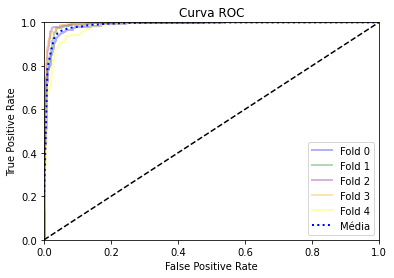

In [158]:
params = {"C":[0.1, 1, 100],
          "kernel":["linear"],
          "probability":[True]}

svm = SVC()

# Melhor classificador
svm = find_parameters(X, y, svm, params)

# Estatisticas do melhor
s = svm.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

# Curva ROC do melhor
plt_roc(s.fpr, s.tpr, s.folds)

### 4. k-NN

O objetivo deste experimento foi avaliar o desepenho do **k-NN** na tarefa de classificação dos exoplanetas, para tal, o número **k** de vizinhos foi variado em {1, 2, 3, ..., 15}.
O algoritmo foi testado com as seguintes métricas de distâncias:

1. euclideana
2. manhattan
3. chebyshev e
4. minkowski

Destas, a distância de xxx obteve o melhor desempenho.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# parametros avaliados
params = {"n_neighbors" = [1, 2, 3],
          "metric" = ["euclidean", "manhattan", "chebyshev"]
         }

k = range(1,15)

estatistica = Estatistica(k)

for i in k:
    knn_classifier = KNeighborsClassifier(n_neighbors=i)

    # separa os dados em k-folds (5)
    score = treinamento(X, y, 5, knn_classifier)
    estatistica.adicionar(score[0], score[1])
        
        
estatistica.plotar("k", "Acurácia")

### 5. Random Forest

Variar o número de árvores e mostrar os resultados graficamente.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

k = range(1,15)

estatistica = Estatistica(k)

for i in k:
    knn_classifier = KNeighborsClassifier(n_neighbors=i)

    # separa os dados em k-folds (5)
    score = treinamento(X, y, 5, knn_classifier)
    estatistica.adicionar(score[0], score[1])
        
        
estatistica.plotar("k", "Acurácia")

### 6. Gradient Tree Boosting

Variar o número de iterações e mostrar os resultados graficamente.

## Performance

Após treinar cada algoritmo e realizar 